# stn-warp

This notebook shows an example usage of the proposed *Flow-based Texture Deformation* and was used to create all images in the thesis.

In [1]:
from stnwarp import TensorFlowFlexTPSReversibleWarper, plot_flow_arrows, plot_flow, sample_based_on_density
from stnwarp import get_all_offsets, sample_offsets, extract_patches, get_offsets_grid, transfer_patch, pad_image, unpad_image
from stnwarp import mse, ssim, psnr_hvs, gaussian_kernel
from stnwarp import warp_channels_from_vfields, warp_from_vfields
from utils import load_image, plot_imshow_grid, normalize_image
import matplotlib.pyplot as plt
from skimage.filters import scharr, gaussian, sobel
from skimage.feature import canny
from skimage.exposure import equalize_adapthist
from skimage.util import pad
from skimage.morphology import dilation, closing
from sklearn.metrics.pairwise import pairwise_distances
import scipy.stats as st
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage.interpolation import geometric_transform
from skimage.transform import warp
import random
import string
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def get_edge_image(image):
    im = canny(image, sigma=1, low_threshold=0.4)#normalize_image((scharr(gaussian(image,sigma=1))**2))
    return im.astype(np.float32)#equalize_adapthist(im, 2)#im#dilation(closing(equalize_adapthist(im, 5)))

def image_style_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    
def get_key():
    return ''.join(random.choices(string.ascii_letters+string.digits, k=6))
    
def save_json(path, data):
    with open(path+'.json', 'x') as file:
        json.dump(data, file)
    
def save_results(key, image_meta=None,
                 losses=None,
                 source_points=None, target_points=None,
                 vfields=None, inv_vfields=None,
                 result1=None, result2=None,
                 blend=None, iblend=None,
                 alphas=None, warp1_steps=None, warp2_steps=None,
                 params=None):
    folder = 'results/'+key
    base = folder+'/'+key
    
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    if image_meta is not None:
        save_json(base+'_paths', image_meta)
    if losses is not None:
        np.savetxt(base+'_losses', losses)
    if source_points is not None or target_points is not None:
        np.save(base+'_source_points', source_points)
        np.save(base+'_target_points', target_points)
        
    if vfields is not None:
        np.save(base+'_vfields', vfields)
        
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        for i, field in enumerate(vfields):
            ax.clear()
            plot_flow(ax, np.rollaxis(field, 2))
            fig.savefig(base+"_iflow{}".format(i))
            ax.clear()
            plot_flow_arrows(ax, np.rollaxis(field,2), field.shape[0], field.shape[1], s=3)
            fig.savefig(base+"_iarrows{}".format(i))
            
    if inv_vfields is not None:
        np.save(base+'_inv_vfields', inv_vfields)
        
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        for i, field in enumerate(inv_vfields):
            ax.clear()
            plot_flow(ax, np.rollaxis(field, 2))
            fig.savefig(base+"_iflow{}".format(i))
            ax.clear()
            plot_flow_arrows(ax, np.rollaxis(field,2), field.shape[0], field.shape[1], s=3)
            fig.savefig(base+"_iarrows{}".format(i))
            
    if result1 is not None:
        plt.imsave(base+'_result1', result1, cmap='gray')
    if result2 is not None:
        plt.imsave(base+'_result2', result2, cmap='gray')
    if blend is not None:
        plt.imsave(base+'_blend', blend, cmap='gray')
    if iblend is not None:
        plt.imsave(base+'_iblend', iblend, cmap='gray')
    if warp1_steps is not None or warp2_steps is not None or alphas is not None:
        for w1, w2, a in zip(warp1_steps, warp2_steps, alphas):
            plt.imsave(base+'_w1_{:.2f}'.format(a).replace(".","_"), w1, cmap='gray')
            plt.imsave(base+'_w2_{:.2f}'.format(a).replace(".","_"), w2, cmap='gray')
    if params is not None:
        save_json(base+'_params', params)

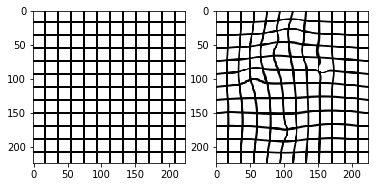

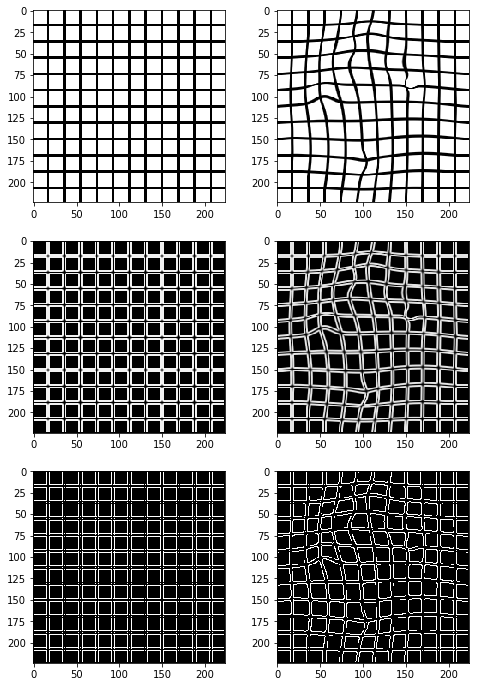

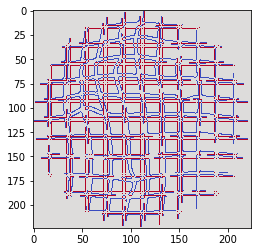

In [3]:
# grid
# paisley_m
# paisley?
im1_path = 'images/reconstruct/grid_m/grid_m.png'
im2_path = 'images/reconstruct/grid_m/grid_mwarped.png'

scale1 = 1
scale2 = 1

cut = 256

image1 = load_image(im1_path, scale1, astype='grayscale', normalize=True)
image2 = load_image(im2_path, scale2, astype='grayscale', normalize=True)

image1c = load_image(im1_path, scale1, astype='rgb')
image2c = load_image(im2_path, scale2, astype='rgb')

image1 = normalize_image(image1[:cut,:cut])
image2 = normalize_image(image2[:cut,:cut])
image1e = get_edge_image(image1)
image2e = get_edge_image(image2)
image1c = normalize_image(image1c[:cut,:cut])
image2c = normalize_image(image2c[:cut,:cut])


PAD_WIDTH = 0
MODE = 'edge'
image1 = pad(image1, PAD_WIDTH, mode=MODE)
image2 = pad(image2, PAD_WIDTH, mode=MODE)
image1e = pad(image1e, PAD_WIDTH, mode=MODE)
image2e = pad(image2e, PAD_WIDTH, mode=MODE)
image1c = pad(image1c, ((PAD_WIDTH,PAD_WIDTH),(PAD_WIDTH,PAD_WIDTH),(0,0)), mode=MODE)
image2c = pad(image2c, ((PAD_WIDTH,PAD_WIDTH),(PAD_WIDTH,PAD_WIDTH),(0,0)), mode=MODE)

image_meta = dict(path1=im1_path, path2=im2_path, scale1=scale1, scale2=scale2, cut=cut, pad=PAD_WIDTH)

#image1e = dilation(closing(image1e))
#image2e = dilation(closing(image2e))

#image1 = canny(image1, sigma=2.)
#image2 = canny(image2, sigma=2.)

fig, axs = plt.subplots(1,2)
axs[0].imshow(image1c)
axs[1].imshow(image2c)

plot_imshow_grid([image1, image2, sobel(image1), sobel(image2), image1e, image2e], shape=(3,2), figsize=(8,12), cmap='gray')
plt.show()

fig, ax = plt.subplots(1,1)
ax.imshow(image1e-image2e, cmap='coolwarm')

assert image1.shape == image2.shape

204 new best loss 0.2936446
256 new best loss 0.2928111
262 new best loss 0.29050156
269 new best loss 0.28772694
270 new best loss 0.28618112
309 new best loss 0.28298557
406 new best loss 0.28130928
407 new best loss 0.27833134
424 new best loss 0.27770162
447 new best loss 0.27555162
613 new best loss 0.27322218
797 new best loss 0.2717586
945 new best loss 0.27154088
1048 new best loss 0.271434
1054 new best loss 0.269703
1055 new best loss 0.2674163
1056 new best loss 0.26512918
1474 new best loss 0.26449358



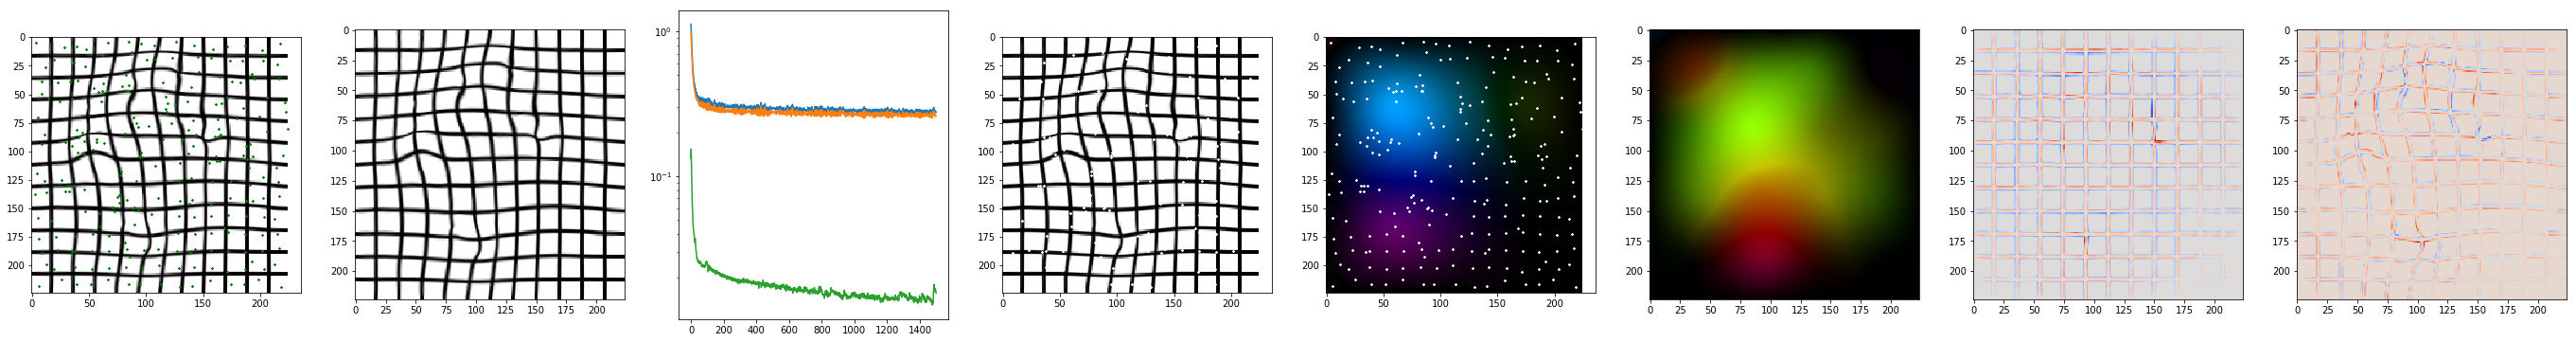

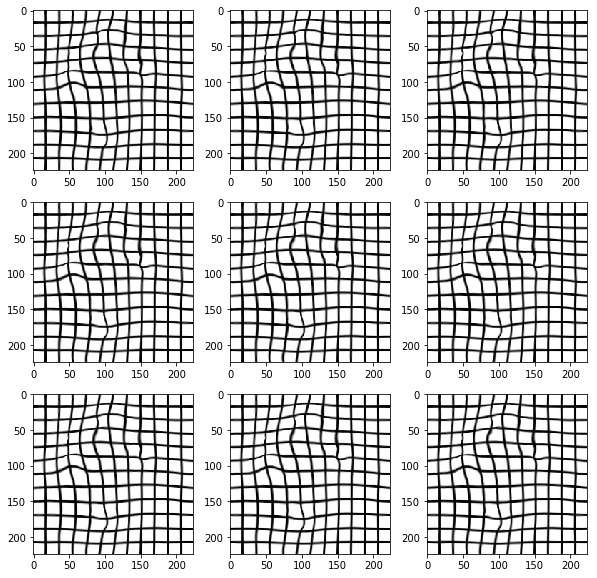

In [7]:
%matplotlib inline

#save_for_later_key = get_key()
#save_results(save_for_later_key, image_meta=image_meta)
#print("key:",save_for_later_key)


fig, axs = plt.subplots(1,8, figsize=(48,6))

NUM_ITER = 1500

dimage1e = np.copy(image1e)

density_image = pad_image(unpad_image(np.copy(image1e),PAD_WIDTH),PAD_WIDTH)


errors = np.zeros((3,NUM_ITER))

best_loss = np.inf
best_results = []
best_warps = []
best_inv_warps = []


params = dict(image_shape=image1e.shape,
              patch_shape=image1e.shape,
              image_value_range=[0,1],
              learning_rate=1.,
              num_layer_points=[4, 16, 225],
              layer_retrieval_methods=['grid']*3,
              regularization_weight=0.,
              layer_st_loss_weights=[1e-6,1e-6,0.1], # psnr 1e-2
              layer_si_loss_weights=[0]*3,
              metric='mse',
              iterations=NUM_ITER,
              num_boundary_points=5,
              smooth_sigma=None,
              sobel_filter=False,
              lock_source_points=False,
              bidirectional=True)

warper = TensorFlowFlexTPSReversibleWarper(patch_shape=)

np.reshape()

#save_results(save_for_later_key, params=params)

axs[0].imshow(density_image, cmap='gray')
fig.canvas.draw()

with tqdm(total=NUM_ITER) as pbar:
    def cb(i):
        global best_loss
        loss, ploss, stloss = warper.get_current(['loss','pixel_loss', 'st_loss'])
        errors[0,i] = loss
        errors[1,i] = ploss
        errors[2,i] = stloss
        
        if loss < best_loss:
            vfields, inv_vfields, d1 = warper.get_current(['vector_fields','inverse_vector_fields','displaced1'])
            d1 = np.reshape(d1, image1.shape)
            best_loss = loss
            best_results.append(np.copy(d1))
            best_warps.append(np.copy(vfields))
            best_inv_warps.append(np.copy(inv_vfields))
            if i > 200:
                print(i,"new best loss",best_loss)
        

        #if i > 200 and loss == best_loss or i % 50 == 0 or i == NUM_ITER-1:
        if i % 200 == 0 or i == NUM_ITER-1:
            d1p, d2p, d1, d2, sp, i1p, i2p, vfields = warper.get_current(['displaced1_postproc', 'displaced2_postproc',
                                                                          'displaced1', 'displaced2', 'source_points',
                                                                          'image1_t_postproc', 'image2_t_postproc',
                                                                          'vector_fields'])
            d1p = np.reshape(d1p, image1.shape)
            d2p = np.reshape(d2p, image1.shape)
            d1 = np.reshape(d1, image1.shape)
            d2 = np.reshape(d2, image1.shape)
            i1p = np.reshape(i1p, image1.shape)
            i2p = np.reshape(i2p, image1.shape)
            axs[0].clear()
            axs[0].imshow(d1p, cmap='gray')
            axs[0].scatter(sp[0,:,1],sp[0,:,0],marker='x', color='green',s=3.)

            axs[1].clear()
            axs[1].imshow(unpad_image(d1, PAD_WIDTH), cmap='gray')

            axs[2].clear()
            axs[2].semilogy(errors[0,:(i+1)], color='C0')
            axs[2].semilogy(errors[1,:(i+1)], color='C1')
            axs[2].semilogy(errors[2,:(i+1)], color='C2')

            axs[3].clear()
            axs[3].imshow(0.5*d1+0.5*i2p, cmap='gray')
            axs[3].scatter(sp[0,:,1],sp[0,:,0],marker='x', color='white',s=3.)

            axs[4].clear()
            plot_flow(axs[4], np.rollaxis(vfields[0],2))
            axs[4].scatter(sp[0,:,1],sp[0,:,0],marker='x', color='white',s=3.)
            
            if len(vfields) > 1:
                axs[5].clear()
                plot_flow(axs[5], np.rollaxis(vfields[1],2))
                
            axs[6].clear()
            axs[6].imshow(d2p-i1p, cmap='coolwarm')
            
            axs[7].clear()
            axs[7].imshow(d1p-i2p, cmap='coolwarm')

            fig.canvas.draw()
        pbar.update(1)
    warper.load_images(image1,image2)
    warper.evaluate(callback=cb)
    
#save_results(save_for_later_key, losses=errors[0])

fig, axs = plt.subplots(3,3,figsize=(10,10))
for b, ax in zip(best_results[-9:], np.ravel(axs)):
    ax.imshow(b, cmap='gray')
    
plt.show()

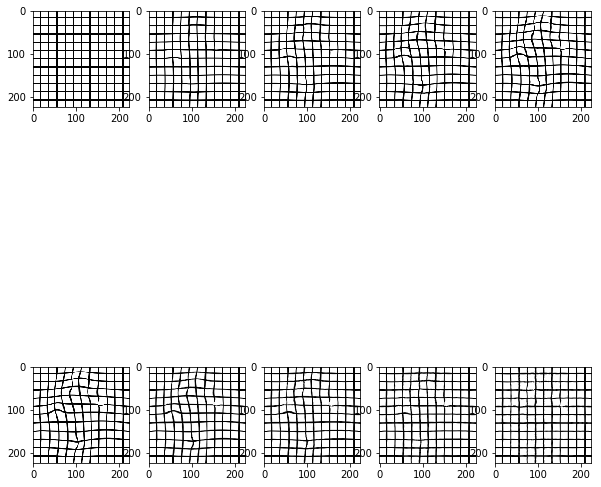

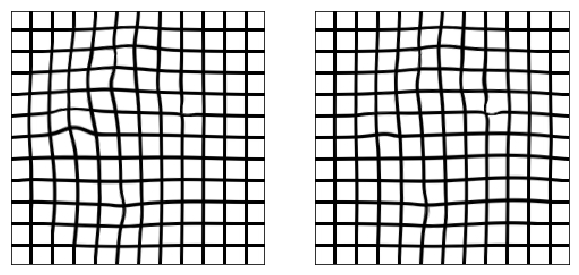

In [5]:
%matplotlib inline

vfields = best_warps[-1]
inv_vfields = best_inv_warps[-1]
num_warps = 5

#save_results(save_for_later_key, vfields=vfields, inv_vfields=inv_vfields)

alphas = np.linspace(0,1,num_warps,endpoint=True)

warps1 = [unpad_image(warp_channels_from_vfields(image1c, a*vfields), PAD_WIDTH) for a in tqdm(alphas)]
warps2 = [unpad_image(warp_channels_from_vfields(image2c, a*inv_vfields), PAD_WIDTH) for a in tqdm(alphas)]

# the long way to create a simple mask
a = np.linspace(0,1,vfields.shape[2],endpoint=True)
a = np.reshape(a, (1,1,*a.shape,1))
a = np.repeat(a, vfields.shape[1], axis=1)
a = np.repeat(a, vfields.shape[0], axis=0)
#a = np.repeat(a, vfields.shape[3], axis=3)
ia = a[:,:,::-1,:]

vfields01 = a*vfields
vfields10 = ia*vfields
inv_vfields01 = a*inv_vfields
inv_vfields10 = ia*inv_vfields

fig, axs = plt.subplots(2,num_warps,figsize=(num_warps*2,12))
for ax, w in zip(np.ravel(axs), warps1+warps2):
    ax.imshow(unpad_image(w,PAD_WIDTH), cmap='gray')

#save_results(save_for_later_key, result1=warps1[-1], result2=warps2[-1], alphas=alphas, warp1_steps=warps1, warp2_steps=warps2)

blend = unpad_image(np.zeros_like(image1c), PAD_WIDTH)
iblend = unpad_image(np.zeros_like(image1c), PAD_WIDTH)

smooth1_01 = warp_channels_from_vfields(image1c, vfields01)
smooth1_10 = warp_channels_from_vfields(image1c, vfields10)
smooth2_01 = warp_channels_from_vfields(image2c, inv_vfields01)
smooth2_10 = warp_channels_from_vfields(image2c, inv_vfields10)

blend = unpad_image(a[0]*smooth1_10+ia[0]*smooth2_01, PAD_WIDTH)
iblend = unpad_image(a[0]*smooth2_10+ia[0]*smooth1_01, PAD_WIDTH)

#save_results(save_for_later_key, blend=blend, iblend=iblend)

    
fig, axs = plt.subplots(1,2,figsize=(10,5))
for ax in axs:
    image_style_axis(ax)
axs[0].imshow(blend, cmap='gray')
axs[1].imshow(iblend, cmap='gray')